In [1]:
import pm4py
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


### Load Data

In [2]:
logs = pm4py.read_xes('/Users/emadbahreini/University/BIS/Project/Road_Traffic_Fine_Management_Process.xes.gz')
logs_df = pm4py.convert_to_dataframe(logs)

logs_df.head()


/Users/emadbahreini/anaconda3/envs/bis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 150370/150370 [00:12<00:00, 11927.48it/s]


,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN


### Clean Data

In [3]:

# Drop the columns that are not needed
logs_df.drop(columns=[
    'org:resource',
    'vehicleClass',
    'lifecycle:transition',
    'totalPaymentAmount',
    'notificationType',
    'lastSent',
    'matricola',
    'article',
    'points'], inplace=True, axis=1)



# Rename the columns
mapping = {
    logs_df.columns[0]: 'Amount',
    logs_df.columns[1]: 'Dismissal',
    logs_df.columns[2]: 'Activity',
    logs_df.columns[3]: 'CompleteTimestamp',
    logs_df.columns[4]: 'CaseID',
    logs_df.columns[5]: 'Expense',
    logs_df.columns[6]: 'PaymentAmount',
}

logs_df = logs_df.rename(columns=mapping)
logs_df


,Amount,Dismissal,Activity,CompleteTimestamp,CaseID,Expense,PaymentAmount
0,35.0,NIL,Create Fine,2006-07-24 00:00:00+00:00,A1,NaN,NaN
1,NaN,NaN,Send Fine,2006-12-05 00:00:00+00:00,A1,11.00,NaN
2,35.0,NIL,Create Fine,2006-08-02 00:00:00+00:00,A100,NaN,NaN
3,NaN,NaN,Send Fine,2006-12-12 00:00:00+00:00,A100,11.00,NaN
4,NaN,NaN,Insert Fine Notification,2007-01-15 00:00:00+00:00,A100,NaN,NaN
...,...,...,...,...,...,...,...
561465,131.0,NIL,Create Fine,2002-09-07 00:00:00+00:00,V9999,NaN,NaN
561466,NaN,NaN,Send Fine,2002-10-25 00:00:00+00:00,V9999,15.16,NaN
561467,NaN,NaN,Insert Fine Notification,2002-11-04 00:00:00+00:00,V9999,NaN,NaN
561468,262.0,NaN,Add penalty,2003-01-03 00:00:00+00:00,V9999,NaN,NaN


Number of active cases: 145450


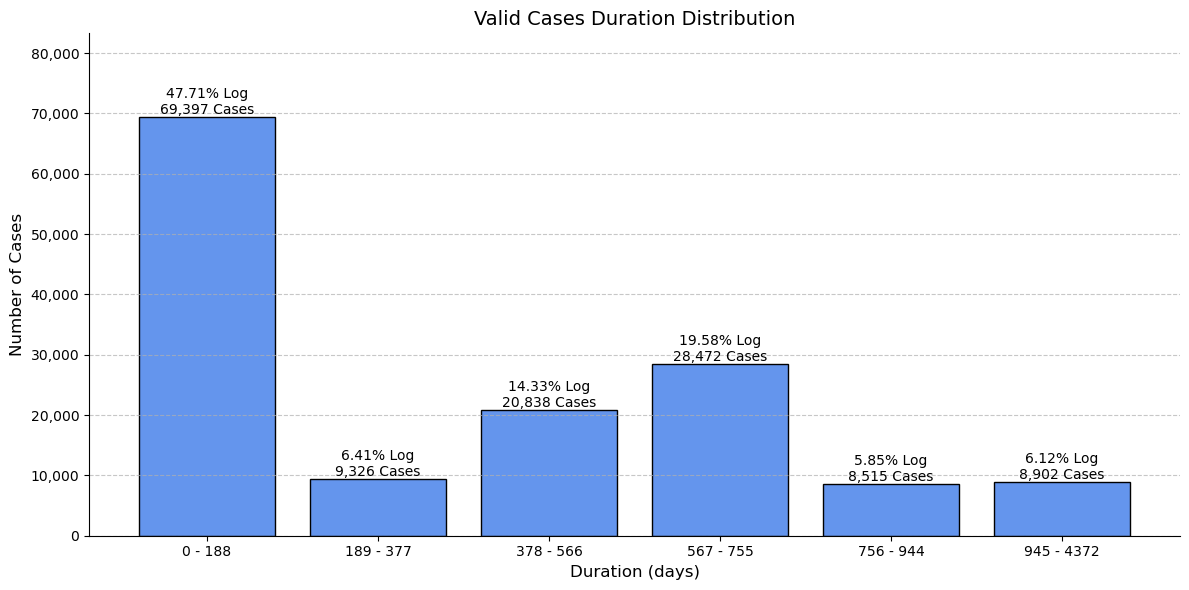

In [4]:

# Calculate the duration of each case
case_durations = logs_df.groupby('CaseID').agg(
    Duration=('CompleteTimestamp', lambda x: (x.max() - x.min()).days)
)

# Filter cases with duration greater than zero
valid_cases = case_durations[case_durations['Duration'] > 0]

# Filter event_logs to include only valid cases
filtered_df_logs = logs_df[logs_df['CaseID'].isin(valid_cases.index)]

# Count unique active cases
active_case_count = filtered_df_logs['CaseID'].nunique()

# Print the result
print(f'Number of active cases: {active_case_count}')


# Define bin edges and labels
bin_edges = [0, 189, 378, 567, 756, 945, 4372]
bin_labels = ['0 - 188', '189 - 377', '378 - 566', '567 - 755', '756 - 944', '945 - 4372']


# Calculate histogram
hist, _ = np.histogram(valid_cases['Duration'], bins=bin_edges)

# Calculate percentages
total_cases = len(valid_cases)
percentages = hist / total_cases * 100

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(bin_labels, hist, edgecolor='black', color='#6495ED')

# Customize the plot
plt.title('Valid Cases Duration Distribution', fontsize=14)
plt.xlabel('Duration (days)', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add value labels on top of each bar
for i, (count, percentage) in enumerate(zip(hist, percentages)):
    plt.text(i, count, f'{percentage:.2f}% Log\n{count:,d} Cases', 
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(hist) * 1.2)  
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

Number of events: 551630
Number of cases: 145450


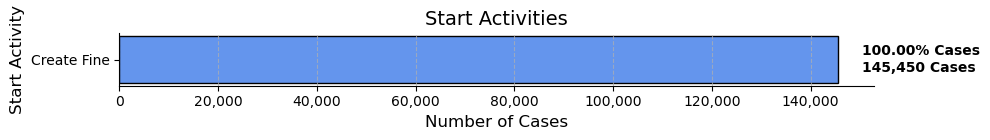

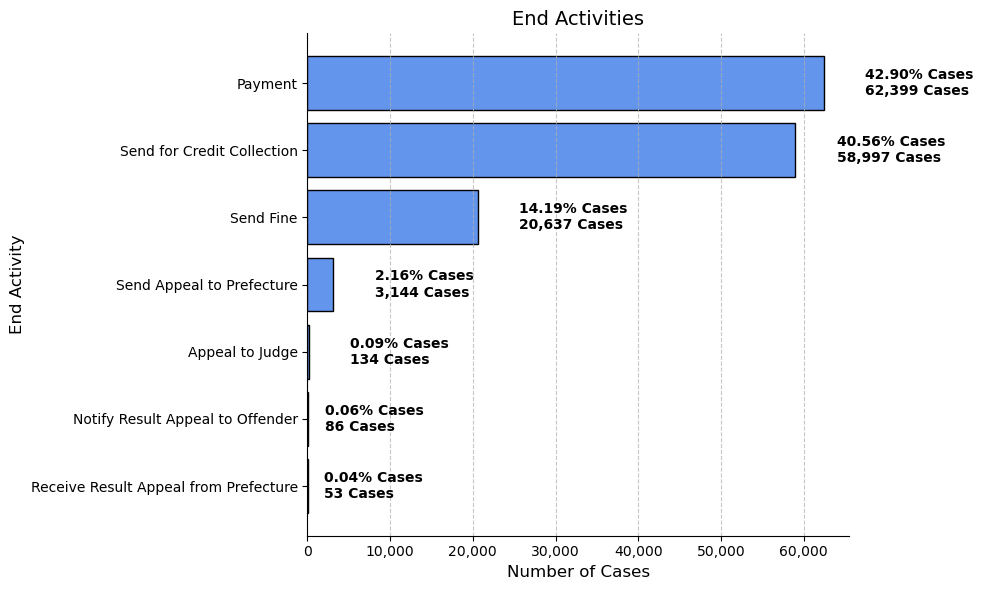

In [5]:
# Calculate the number of events and cases
num_events = len(filtered_df_logs)
num_cases = len(filtered_df_logs['CaseID'].unique())
print(f"Number of events: {num_events}\nNumber of cases: {num_cases}")

# Get start and end activities
start_activities = pm4py.get_start_activities(filtered_df_logs, activity_key='Activity', case_id_key='CaseID', timestamp_key='CompleteTimestamp')
end_activities = pm4py.get_end_activities(filtered_df_logs, activity_key='Activity', case_id_key='CaseID', timestamp_key='CompleteTimestamp')

# Start Activities Plot
start_activities_df = pd.DataFrame(list(start_activities.items()), columns=['Activity', 'Count'])
start_activities_df['Percentage'] = (start_activities_df['Count'] / num_cases) * 100
start_activities_df = start_activities_df.sort_values('Count', ascending=False)

plt.figure(figsize=(10, 1.5))  
bars = plt.barh(start_activities_df['Activity'], start_activities_df['Count'], color='#6495ED', edgecolor='black')

plt.title('Start Activities', fontsize=14)
plt.xlabel('Number of Cases', fontsize=12)
plt.ylabel('Start Activity', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

for i, (count, percentage) in enumerate(zip(start_activities_df['Count'], start_activities_df['Percentage'])):
    plt.text(count+5000, i, f'{percentage:.2f}% Cases\n{count:,d} Cases', 
             va='center', ha='left', fontsize=10, weight='bold')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

# Sort end activities by count
sorted_end_activities = dict(sorted(end_activities.items(), key=lambda item: item[1]))
end_activities_df = pd.DataFrame(list(sorted_end_activities.items()), columns=['Activity', 'Count'])
end_activities_df['Percentage'] = (end_activities_df['Count'] / num_cases) * 100

plt.figure(figsize=(10, 6))
bars = plt.barh(end_activities_df['Activity'], end_activities_df['Count'], color='#6495ED', edgecolor='black')

plt.title('End Activities', fontsize=14)
plt.xlabel('Number of Cases', fontsize=12)
plt.ylabel('End Activity', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

for i, (count, percentage) in enumerate(zip(end_activities_df['Count'], end_activities_df['Percentage'])):
    if i < 2 :
        plt.text(count+2000, i, f'{percentage:.2f}% Cases\n{count:,d} Cases', 
             va='center', ha='left', fontsize=10, weight='bold')
    else:
        plt.text(count+5000, i, f'{percentage:.2f}% Cases\n{count:,d} Cases', 
             va='center', ha='left', fontsize=10, weight='bold')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()



In [6]:
variants = pm4py.get_variants(filtered_df_logs,case_id_key='CaseID',activity_key='Activity',timestamp_key='CompleteTimestamp')
variants_filter = pd.DataFrame(list(variants.items()), columns=['Variant', 'Count'])
variants_filter = variants_filter[variants_filter['Count'] >= 70]
variants_filter.head()

,Variant,Count
0,"(Create Fine, Send Fine)",20267
1,"(Create Fine, Send Fine, Insert Fine Notificat...",56482
2,"(Create Fine, Send Fine, Insert Fine Notificat...",9520
3,"(Create Fine, Send Fine, Insert Fine Notificat...",2497
4,"(Create Fine, Payment)",41569


In [7]:

# Define the specific variants we're interested in
target_variants = [
    ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Payment', 'Add penalty', 'Payment'),
    ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Payment', 'Add penalty', 'Send for Credit Collection'),
    ('Create Fine', 'Payment', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment')
]

# Filter for specific variants
variants_filter = variants_filter[variants_filter['Variant'].isin(target_variants)]

filtered_variants = {v: variants[v] for v in variants_filter['Variant']}
filtered_df_logs = pm4py.filter_variants(filtered_df_logs, filtered_variants, case_id_key='CaseID', activity_key='Activity', timestamp_key='CompleteTimestamp')

# Convert filtered log back to DataFrame if needed
# filtered_df = pm4py.convert_to_dataframe(filtered_log)
num_events = len(filtered_df_logs)
num_cases = len(filtered_df_logs['CaseID'].unique())
print(f"Number of events: {num_events}\nNumber of cases: {num_cases}")

Number of events: 23472
Number of cases: 3912


In [8]:
filtered_df_logs

,Amount,Dismissal,Activity,CompleteTimestamp,CaseID,Expense,PaymentAmount
1812,22.0,NIL,Create Fine,2007-03-25 00:00:00+00:00,A10798,NaN,NaN
1813,NaN,NaN,Send Fine,2007-08-02 00:00:00+00:00,A10798,13.00,NaN
1814,NaN,NaN,Insert Fine Notification,2007-08-11 00:00:00+00:00,A10798,NaN,NaN
1815,NaN,NaN,Payment,2007-09-25 00:00:00+00:00,A10798,NaN,22.00
1816,44.0,NaN,Add penalty,2007-10-10 00:00:00+00:00,A10798,NaN,NaN
...,...,...,...,...,...,...,...
561144,NaN,NaN,Send Fine,2002-12-05 00:00:00+00:00,V9883,15.16,NaN
561145,NaN,NaN,Insert Fine Notification,2002-12-14 00:00:00+00:00,V9883,NaN,NaN
561146,NaN,NaN,Payment,2003-02-10 00:00:00+00:00,V9883,NaN,141.00
561147,262.0,NaN,Add penalty,2003-02-12 00:00:00+00:00,V9883,NaN,NaN


### Analyze the characteristics of these cases:



Statistics for cases with multiple payments (after noise removal):
Number of cases with multiple payments: 3370
Average duration between payments: 121.42 days
Median duration between payments: 84.00 days


/Users/emadbahreini/anaconda3/envs/bis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


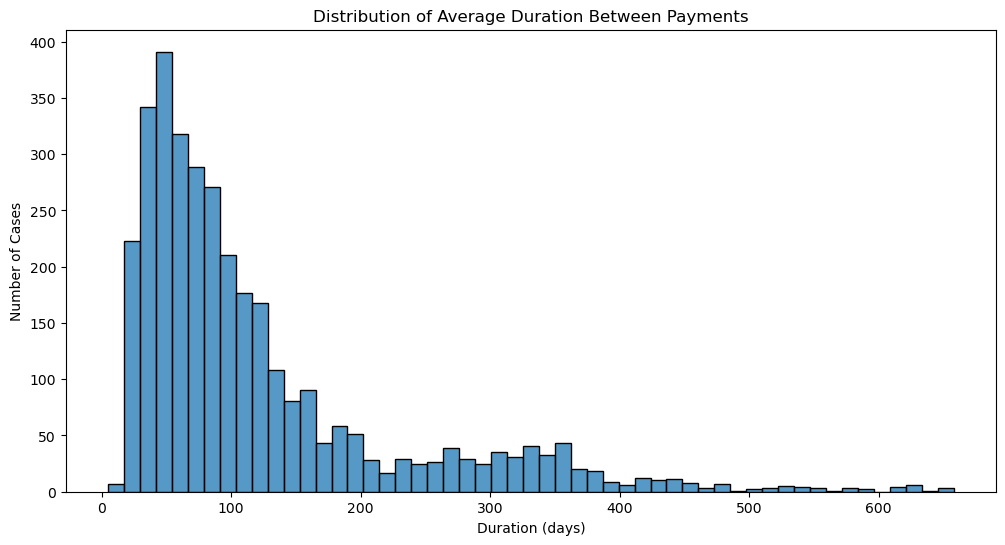

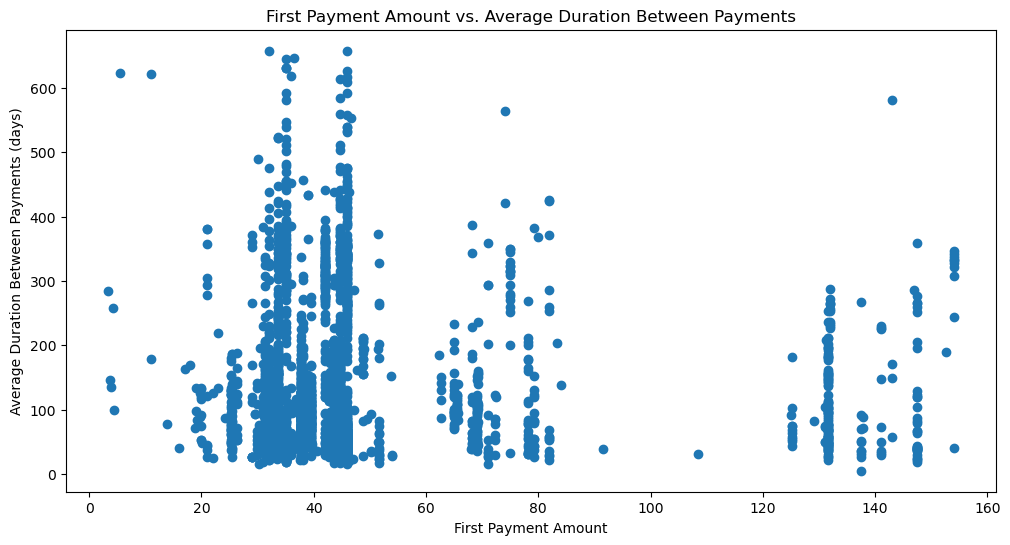

In [9]:
def analyze_payment_durations(case_df):
    payments = case_df[case_df['Activity'] == 'Payment'].sort_values('CompleteTimestamp')    
    durations = payments['CompleteTimestamp'].diff()  
    return pd.Series({
        'DurationBetweenPayments': durations.mean(),
        'FirstPaymentAmount': payments['PaymentAmount'].iloc[0],
        'TotalPaymentAmount': payments['PaymentAmount'].sum(),
        'FirstToLastPaymentDuration': payments['CompleteTimestamp'].iloc[-1] - payments['CompleteTimestamp'].iloc[0]
    })

# Apply the function to each case
payment_analysis = filtered_df_logs.groupby('CaseID').apply(analyze_payment_durations, include_groups=False)

# Filter for cases with multiple payments
multiple_payments = payment_analysis.copy()

# Convert durations to days
multiple_payments['DurationBetweenPaymentsDays'] = multiple_payments['DurationBetweenPayments'].dt.days
multiple_payments['FirstToLastPaymentDurationDays'] = multiple_payments['FirstToLastPaymentDuration'].dt.days

# Remove extreme outliers (e.g., durations more than 5 standard deviations from the mean)
def remove_outliers(df, column):
    mean = df[column].mean()
    std = df[column].std()
    return df[(df[column] <= mean + 5*std) & (df[column] >= mean - 5*std)]

multiple_payments = remove_outliers(multiple_payments, 'DurationBetweenPaymentsDays')
multiple_payments = remove_outliers(multiple_payments, 'FirstToLastPaymentDurationDays')

# Remove cases with unreasonably high payment amounts (e.g., more than 6 times the median)
median_payment = multiple_payments['TotalPaymentAmount'].median()
multiple_payments = multiple_payments[multiple_payments['TotalPaymentAmount'] <= 6 * median_payment]

print("Statistics for cases with multiple payments (after noise removal):")
print(f"Number of cases with multiple payments: {len(multiple_payments)}")
print(f"Average duration between payments: {multiple_payments['DurationBetweenPaymentsDays'].mean():.2f} days")
print(f"Median duration between payments: {multiple_payments['DurationBetweenPaymentsDays'].median():.2f} days")

# Visualizations
plt.figure(figsize=(12, 6))
sns.histplot(multiple_payments['DurationBetweenPaymentsDays'],)
plt.title('Distribution of Average Duration Between Payments')
plt.xlabel('Duration (days)')
plt.ylabel('Number of Cases')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(multiple_payments['FirstPaymentAmount'], multiple_payments['DurationBetweenPaymentsDays'])
plt.title('First Payment Amount vs. Average Duration Between Payments')
plt.xlabel('First Payment Amount')
plt.ylabel('Average Duration Between Payments (days)')
plt.show()


### Alpha Miner

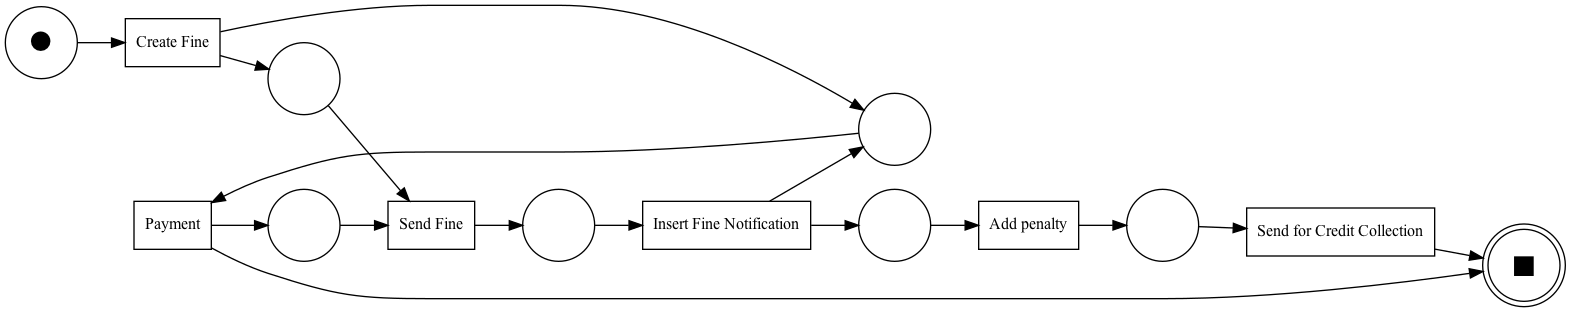

In [12]:

# Apply Alpha Miner algorithm to discover Petri net
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(filtered_df_logs,case_id_key='CaseID',activity_key='Activity',timestamp_key='CompleteTimestamp')

# Visualize the Petri net
pm4py.view_petri_net(net, initial_marking, final_marking, format='png')


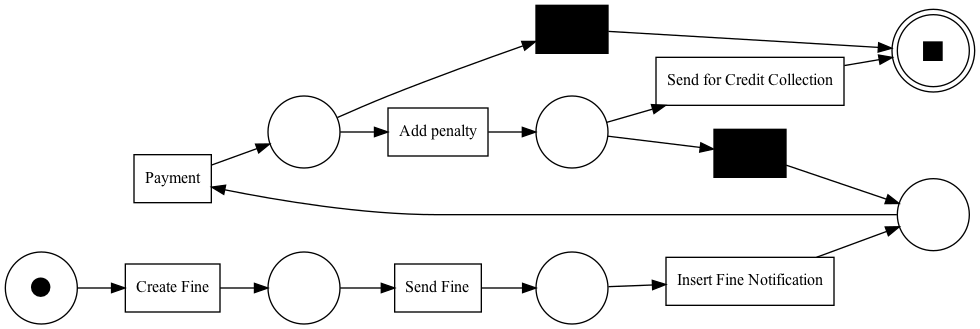

In [13]:
net_hm, im_hm, fm_hm = pm4py.discover_petri_net_heuristics(filtered_df_logs,case_id_key='CaseID',activity_key='Activity',timestamp_key='CompleteTimestamp',dependency_threshold=0.85)
pm4py.view_petri_net(net_hm, im_hm, fm_hm, format='png')

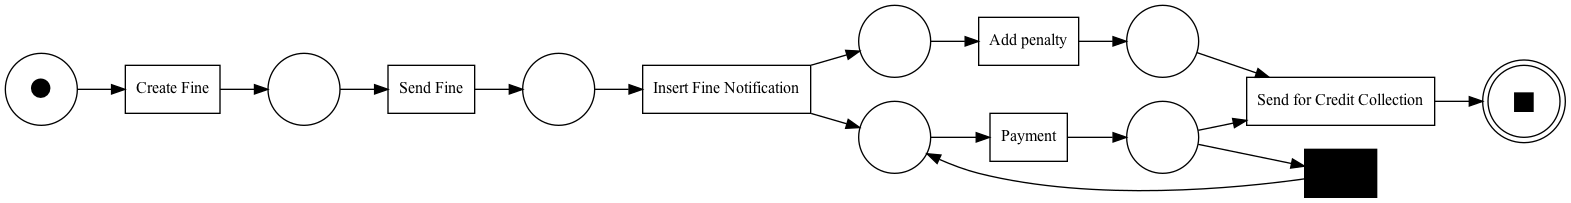

In [15]:
net_im, im_im, fm_im = pm4py.discover_petri_net_inductive(filtered_df_logs,case_id_key='CaseID',activity_key='Activity',timestamp_key='CompleteTimestamp', noise_threshold=0.9)
pm4py.view_petri_net(net_im, im_im, fm_im, format='png')

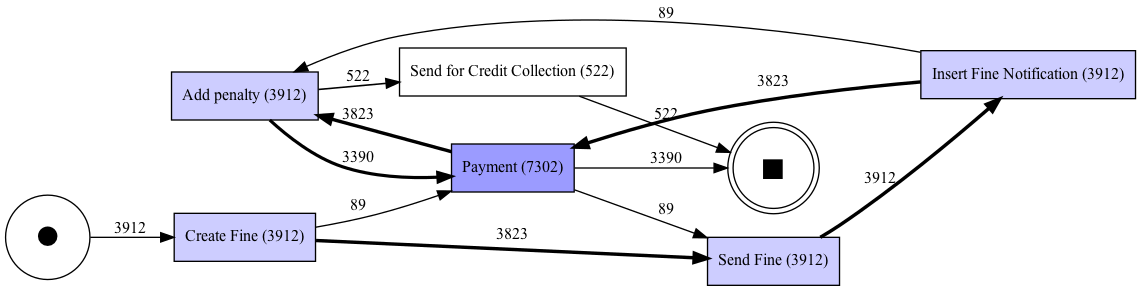

In [37]:
dfg, start_activities, end_activities = pm4py.discover_dfg(filtered_df_logs)
pm4py.view_dfg(dfg, start_activities, end_activities, format='png')

In [22]:
# Calculate Fitness for each algorithm
fitness_am = pm4py.fitness_token_based_replay(filtered_df_logs, net_am, im_am, fm_am,case_id_key='CaseID',activity_key='Activity',timestamp_key='CompleteTimestamp', )
fitness_hm = pm4py.fitness_alignments(filtered_df_logs, net_hm, im_hm, fm_hm,case_id_key='CaseID',activity_key='Activity',timestamp_key='CompleteTimestamp', )
fitness_im = pm4py.fitness_alignments(filtered_df_logs, net_im, im_im, fm_im,case_id_key='CaseID',activity_key='Activity',timestamp_key='CompleteTimestamp', )

# Calculate Precision for each algorithm
precision_am = pm4py.precision_token_based_replay(filtered_df_logs, net_am, im_am, fm_am,case_id_key='CaseID',activity_key='Activity',timestamp_key='CompleteTimestamp', )
precision_hm = pm4py.precision_alignments(filtered_df_logs, net_hm, im_hm, fm_hm,case_id_key='CaseID',activity_key='Activity',timestamp_key='CompleteTimestamp', )
precision_im = pm4py.precision_alignments(filtered_df_logs, net_im, im_im, fm_im,case_id_key='CaseID',activity_key='Activity',timestamp_key='CompleteTimestamp', )
filtered_df_logs = filtered_df_logs.rename(columns={
    "CaseID": "case:concept:name",
    "Activity": "concept:name",
    "CompleteTimestamp": "time:timestamp"
})
# Calculate Generalization for each algorithm
gen_am = pm4py.algo.evaluation.generalization.algorithm.apply(filtered_df_logs, net_am, im_am, fm_am,)
gen_hm = pm4py.algo.evaluation.generalization.algorithm.apply(filtered_df_logs, net_hm, im_hm, fm_hm)
gen_im = pm4py.algo.evaluation.generalization.algorithm.apply(filtered_df_logs, net_im, im_im, fm_im)

# Calculate Simplicity for each algorithm
simp_am = pm4py.algo.evaluation.simplicity.algorithm.apply(net_am)
simp_hm = pm4py.algo.evaluation.simplicity.algorithm.apply(net_hm)
simp_im = pm4py.algo.evaluation.simplicity.algorithm.apply(net_im)

print("Fitness for Alpha Miner: ", f"{fitness_am['log_fitness']:0.3f}")
print("Fitness for Heuristic Miner: ", f"{fitness_hm['log_fitness']:0.3f}")
print("Fitness for Inductive Miner: ", f"{fitness_im['log_fitness']:0.3f}")

print("\nPrecision for Alpha Miner: ", f"{precision_am:0.3f}")
print("Precision for Heuristic Miner: ", f"{precision_hm:0.3f}")
print("Precision for Inductive Miner: ", f"{precision_im:0.3f}")

print("\nGeneralization for Alpha Miner: ", f"{gen_am:0.3f}")
print("Generalization for Heuristic Miner: ", f"{gen_hm:0.3f}")
print("Generalization for Inductive Miner: ", f"{gen_im:0.3f}")

print("\nSimplicity for Alpha Miner: ", f"{simp_am:0.3f}")
print("Simplicity for Heuristic Miner: ", f"{simp_hm:0.3f}")
print("Simplicity for Inductive Miner: ", f"{simp_im:0.3f}")

replaying log with TBR, completed traces :: 100%|██████████| 9/9 [00:00<00:00, 15075.37it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 4920.97it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 5769.33it/s]
replaying log with TBR, completed traces :: 100%|██████████| 3/3 [00:00<00:00, 307.78it/s]

Fitness for Alpha Miner:  0.762
Fitness for Heuristic Miner:  0.995
Fitness for Inductive Miner:  0.926

Precision for Alpha Miner:  0.994
Precision for Heuristic Miner:  1.000
Precision for Inductive Miner:  0.859

Generalization for Alpha Miner:  0.980
Generalization for Heuristic Miner:  0.981
Generalization for Inductive Miner:  0.980

Simplicity for Alpha Miner:  0.778
Simplicity for Heuristic Miner:  0.882
Simplicity for Inductive Miner:  0.882


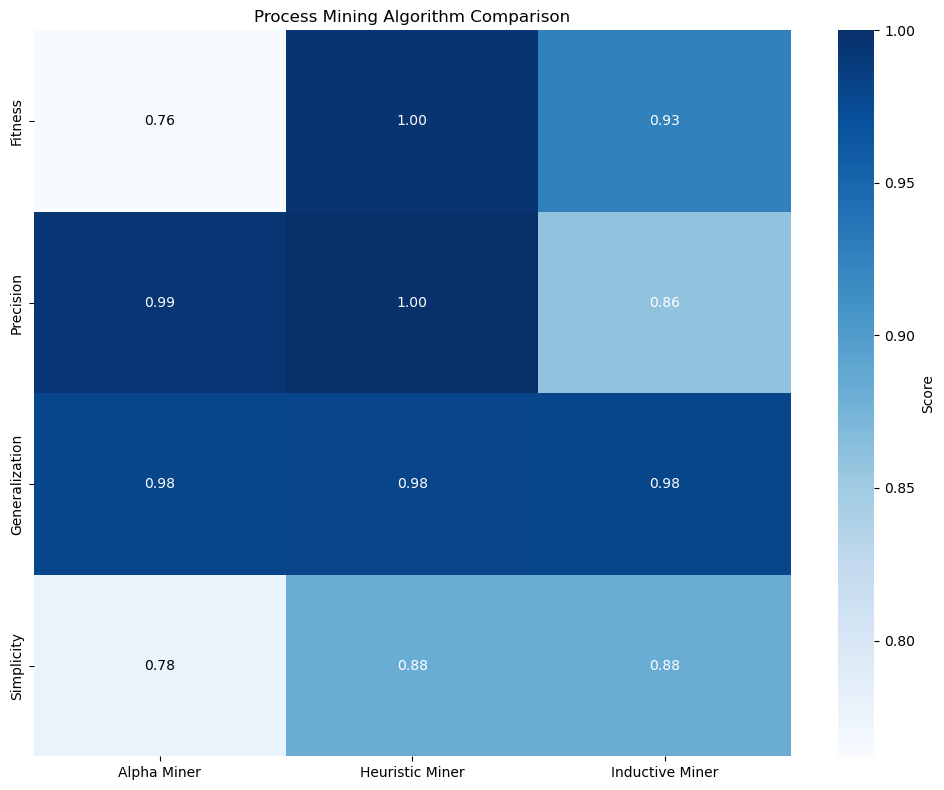

In [36]:
# Organize data into a matrix
data = np.array([
    [fitness_am['log_fitness'], fitness_hm['log_fitness'], fitness_im['log_fitness']],
    [precision_am, precision_hm, precision_im],
    [gen_am, gen_hm, gen_im],
    [simp_am, simp_hm, simp_im]
])

# Define labels
algorithms = ['Alpha Miner', 'Heuristic Miner', 'Inductive Miner']
metrics = ['Fitness', 'Precision', 'Generalization', 'Simplicity']

# Create heatmap
plt.figure(figsize=(10, 8))
heatmap =sns.heatmap(data, fmt='.3f', cmap='Blues',annot=False, cbar=True, 
            xticklabels=algorithms, yticklabels=metrics, cbar_kws={'label': 'Score'})
# Loop over the data to add text annotations
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        text_color = "white" if data[i, j] > 0.8 else "black"
        heatmap.text(j + 0.5, i + 0.5, f"{data[i, j]:.2f}",
                     ha="center", va="center", color=text_color)


plt.title('Process Mining Algorithm Comparison')
plt.tight_layout()
plt.show()